**Table of contents**<a id='toc0_'></a>    
- 1. [Load data        ](#toc1_)    
  - 1.1. [Load tremor catalog      ](#toc1_1_)    
  - 1.2. [Load earthquake catalog  ](#toc1_2_)    
  - 1.3. [Get tremor depth by projecting onto slab     ](#toc1_3_)    
- 2. [Project tremor along strike    ](#toc2_)    
- 3. [Trim catalogs    ](#toc3_)    
- 4. [Measure earthquake tremor distance   ](#toc4_)    
- 5. [Count earthquakes "felt" by tremor        ](#toc5_)    
- 6. [Inspect results  ](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [52]:
# Imports
%matplotlib widget 
import numpy as np
import pandas as pd
import io
import requests

from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    workdir = '/Users/gaspard/Documents/work/'

# 1. <a id='toc1_'></a>Load data         [&#128285;](#toc0_)

## 1.1. <a id='toc1_1_'></a>Load tremor catalog       [&#128285;](#toc0_)

In [53]:
# Load the data
path = workdir + 'projects/data/Catalogs/nz_todd16_1015/nz_tremor_todd16_1015.csv'
names = ['date', 'lat', 'lon']
trm = pd.read_csv(path, names=names, skiprows=1)
trm['date'] = pd.to_datetime(trm['date'])

day0 = np.datetime64('2004-01-01')
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

## 1.2. <a id='toc1_2_'></a>Load earthquake catalog   [&#128285;](#toc0_)

In [54]:
# Load geonet catalog
url1 = "https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2013-03-01&enddate=2016-01-01T0:00:00"
url2 = "https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2010-07-01&enddate=2013-03-01"
url3 = "https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2010-01-01T0:00:00&enddate=2010-07-01"

eq = pd.DataFrame()
for url in [url1, url2, url3]:
    print(url)
    eq = pd.concat([eq, pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))])

eq['date'] = pd.to_datetime(eq['origintime'])
eq.date = eq.date.values
eq = eq.sort_values('date')
eq.reset_index(drop=True, inplace=True)

eq = eq[['date', 'longitude', 'latitude', 'depth', 'magnitude']]
eq.rename(columns={'longitude': 'lon', 'latitude': 'lat', 'magnitude': 'mag'}, inplace=True)

min_lon = eq.lon.min()
max_lon= eq.lon.max()
min_lat = eq.lat.min()
max_lat = eq.lat.max()

https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2013-03-01&enddate=2016-01-01T0:00:00
https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2010-07-01&enddate=2013-03-01
https://quakesearch.geonet.org.nz/csv?bbox=176,-40.5,180,-36.5&startdate=2010-01-01T0:00:00&enddate=2010-07-01


## 1.3. <a id='toc1_3_'></a>Get tremor depth by projecting onto slab      [&#128285;](#toc0_)

In [55]:
# Project tremor onto slab
# --> Load slab
path = workdir + "projects/data/Slabs/new_zealand/ker_slab2_dep_02.24.18.xyz"
slab = pd.read_csv(path, names=['lon', 'lat', 'depth'], sep=',')

slab = slab[(slab.lon > min_lon) & (slab.lon < max_lon) & (slab.lat > min_lat) & (slab.lat < max_lat) & (~np.isnan(slab.depth))]
slab.reset_index(drop=True, inplace=True)
slab.depth *= -1

In [56]:
# Project tremor onto slab: find nearest neighbor
# --> Convert to cartesian coordinates
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(crs, trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(crs, eq.lon.values, eq.lat.values)
slab_coords = crs.transform_points(crs, slab.lon.values, slab.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000
slab.loc[:, 'x'] = slab_coords[:, 0]/1000
slab.loc[:, 'y'] = slab_coords[:, 1]/1000

# --> Find nearest neighbor  
tree = cKDTree(slab[['x', 'y']].values)
dist, idx = tree.query(trm[['x', 'y']].values)
trm['depth'] = slab['depth'].values[idx]

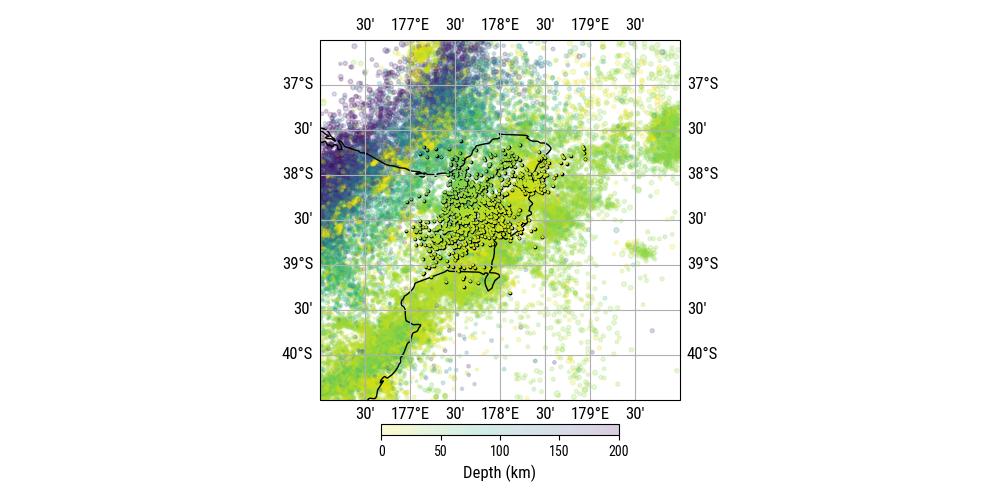

In [57]:
# Plot it
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(trm.lon, trm.lat, s=3, c='k', transform=ccrs.PlateCarree(), zorder=10)
ax.scatter(trm.lon, trm.lat, s=1, c=trm.depth, transform=ccrs.PlateCarree(), zorder=10, cmap='viridis_r', vmin=0, vmax=200)
sc = ax.scatter(eq.lon[eq.depth<200], eq.lat[eq.depth<200], s=eq.mag[eq.depth<200]**2, c=eq.depth[eq.depth<200], transform=ccrs.PlateCarree(), alpha=.2, cmap='viridis_r', vmin=0, vmax=200)
plt.colorbar(sc, label='Depth (km)', pad=0.06, fraction=0.03, orientation='horizontal')

plt.tight_layout()
plt.show()

# 2. <a id='toc2_'></a>Project tremor along strike     [&#128285;](#toc0_)

In [58]:
# Define strike
# --> Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000

# Define along-strike: fit a polynomial to the tremor line
p_strike = np.polyfit(trm.x, trm.y, 1)

# --> Define a strike line with evenly spaced points along it
x0, y0 = -100, np.polyval(p_strike, -100)   # initial point
ds = .01 # spacing along the curve in km

X, Y = [], []  # initialize the location of the points along the line
X.append(x0)
Y.append(y0)
x = x0
while x < 110:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dx = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), x))**2)
    x += dx
    y = np.polyval(p_strike, x)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> Find nearest neighbor — but the distance matrix is huge, so make a tree of the strike points 
# to have a rough first guess before computing the nearest neighbor

tree = cKDTree(np.column_stack((X, Y)))
trm_across_strike_dist, trm_nearest_idx = tree.query(np.column_stack((trm.x, trm.y)))

trm_along_strike_dist = S[trm_nearest_idx]

trm['xf'] = trm_along_strike_dist - trm_along_strike_dist.min()
trm['yf'] = trm_across_strike_dist

# Project earthquakes along-strike: nearest point from each event to the strike line (~1min for 1.7M events)
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((eq.x, eq.y)))
eq_along_strike_dist = S[eq_nearest_idx]

eq['xf'] = eq_along_strike_dist - trm_along_strike_dist.min()  # xf or xfault: along-strike distance in km
eq['yf'] = eq_across_strike_dist  # yf or yfault: across-strike distance in km

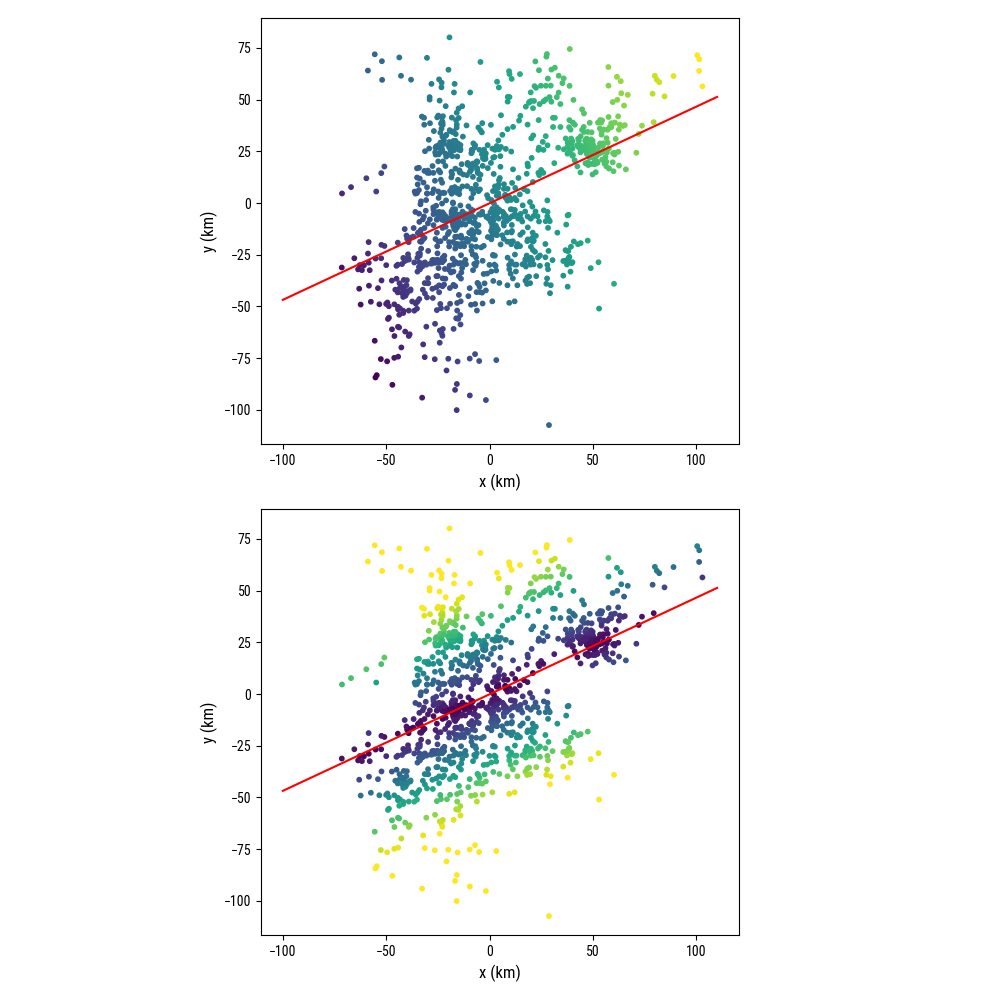

In [59]:
# Show
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlabel('x (km)')  
    ax.set_ylabel('y (km)')
    ax.plot(X, Y, 'r', zorder=10)

# axes[0].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_along_strike_dist, ec='k', cmap='viridis', vmin=0, vmax=1500)
axes[0].scatter(trm.x, trm.y, s=10, c=trm.xf, cmap='viridis', vmin=0, vmax=200)

# axes[1].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_across_strike_dist, ec='k', cmap='viridis')
axes[1].scatter(trm.x, trm.y, s=10, c=trm.yf, cmap='viridis', vmax=50)

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Trim catalogs     [&#128285;](#toc0_)

In [60]:
# Trim earthquakes and tremor to same time period
print('Tremor', trm.date.min(), trm.date.max())
print('Earthquakes', eq.date.min(), eq.date.max())

interval = [np.datetime64('2010-01-01'), np.datetime64('2016-01-01')]
eq = eq[(eq.date.values > interval[0]) & (eq.date.values < interval[1])]
trm = trm[(trm.date.values > interval[0]) & (trm.date.values < interval[1])]

print('\nChosen interval', interval)

Tremor 2010-01-24 14:24:00 2015-11-25 18:20:09
Earthquakes 2010-01-01 00:11:03.452000 2015-12-31 23:47:22.711000

Chosen interval [numpy.datetime64('2010-01-01'), numpy.datetime64('2016-01-01')]


# 4. <a id='toc4_'></a>Measure earthquake tremor distance    [&#128285;](#toc0_)

In [61]:
# Measure distance between earthquakes and the nearest tremor event
tree = cKDTree(np.column_stack((trm.x.values, trm.y.values, trm.depth.values)))

dist2trm, idx = tree.query(np.column_stack((eq.x, eq.y, eq.depth)))
eq['dist2trm'] = dist2trm

In [62]:
# Save processed earthquakes (trimmed, distance to tremor computed)
path = 'data/hikurangi/processed/hiku_eq_0110_0116.csv'
print('Saving to ', path)
eq.to_csv(path, index=False)

Saving to  data/hikurangi/processed/hiku_eq_0110_0116.csv


# 5. <a id='toc5_'></a>Count earthquakes "felt" by tremor         [&#128285;](#toc0_)

In [63]:
# Which distance and magnitude bins
min_mags = [2.4, 2.2, 2., 1.8, 1.5, 1.]
distances = [10, 20, 30, 50, 100]

In [64]:
# Run through minimum magnitudes and distance, and compute number of earthquakes within distance of tremor (~10 min for the whole run)

for min_mag in min_mags:
    # --> Select earthquakes
    selected_eq = eq[
        (eq.mag >= min_mag) \
        & (eq.dist2trm <= np.max(distances))
    ]
    print('Mmin =', min_mag, 'Neq =', len(selected_eq))

    # --> Make trees
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(trm[['x', 'y', 'depth']].values)
    
    for dist in distances:
        print('d <', dist)
        # Query tremor tree to find which earthquakes are closer than `dist`
        eq_neighbors_idxs = trm_tree.query_ball_tree(eq_tree, dist)  # a tuple of eq indices for each tremor event

        # Count number of neighbors for each tremor event
        n_eq_neighbors = np.array([len(e) for e in eq_neighbors_idxs])

        # Convert to number of eq neighbors per year analyzed
        n_eq_neighbors = n_eq_neighbors / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

        # Store information in tremor dataset
        new_key = "m{:.1f}in{:d}km".format(min_mag, dist)
        trm[new_key] = n_eq_neighbors

Mmin = 2.4 Neq = 10787
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.2 Neq = 16116
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.0 Neq = 21971
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.8 Neq = 27048
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.5 Neq = 31692
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.0 Neq = 32999
d < 10
d < 20
d < 30
d < 50
d < 100


In [65]:
# Save processed tremor dataset
path = 'data/hikurangi/processed/hiku_trm_0110_0116.csv'
print('Saving at', path)
trm.to_csv(path, index=False)

Saving at data/hikurangi/processed/hiku_trm_0110_0116.csv


# 6. <a id='toc6_'></a>Inspect results   [&#128285;](#toc0_)

In [66]:
# Load processed results
trm = pd.read_csv('data/hikurangi/processed/hiku_trm_0110_0116.csv')
eq = pd.read_csv('data/hikurangi/processed/hiku_eq_0110_0116.csv')

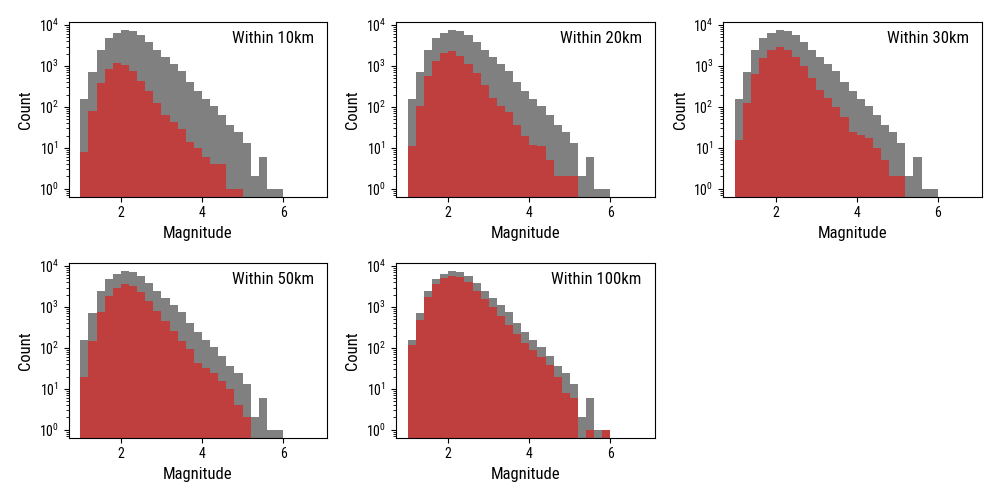

In [67]:
# Magnitude of completeness for each distance

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for ii in range(6):
    if ii == 5: axes[ii//3, ii%3].remove() ; continue
    ax = axes[ii//3, ii%3]
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.text(.95, .95, 'Within {:d}km'.format(distances[ii]), va='top', ha='right', transform=ax.transAxes)

    ax.hist(eq.mag.values, bins=np.arange(1, 7, .2), fc='gray', ec='none')
    ax.hist(eq.mag[(eq.mag > 1) & (eq.dist2trm < distances[ii])].values, bins=np.arange(1, 7, .2), fc=to_rgba('r', .5), ec='none')

plt.tight_layout()
plt.show()

In [68]:
# Which distance/minimum magnitude for maps
min_mag = 2.2

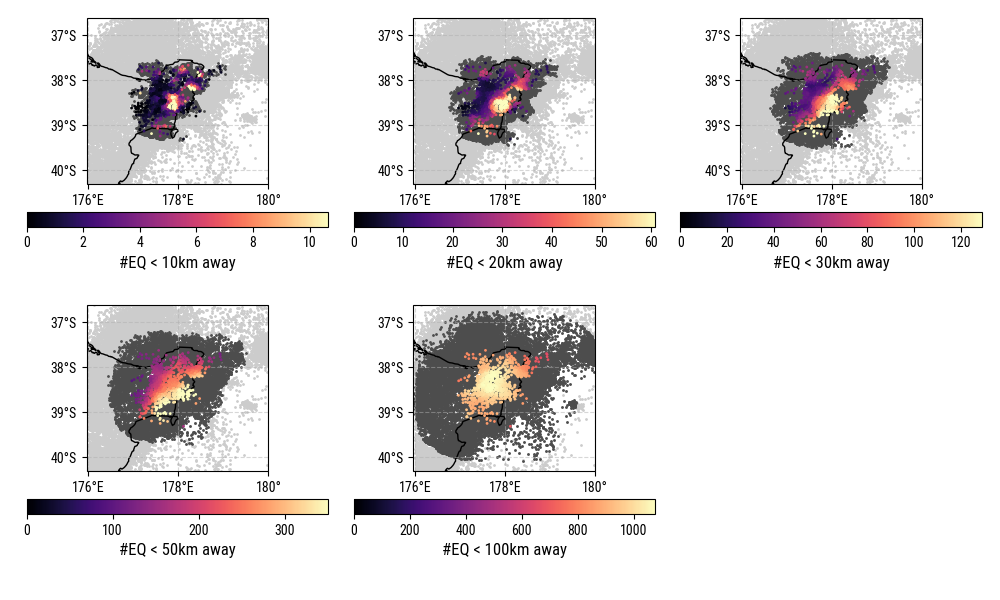

In [69]:
# Maps
lon_min = trm.lon.min() - 1
lon_max = trm.lon.max() + 1
lat_min = trm.lat.min() - 1
lat_max = trm.lat.max() + 1
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 6))
axes = [plt.subplot(2, 3, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(distances)), np.array(axes).flatten()):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=trm['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(trm['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], 95), zorder=2, label='Tremor')
    ax.scatter(eq[eq.dist2trm < distances[ii]].lon, eq[eq.dist2trm < distances[ii]].lat, c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(distances[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    # Colorbar
    x_min_ax = 0.5; y_min_ax = -0.2
    w_ax = 0.45; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    cbar = plt.colorbar(sc, orientation='horizontal', label="#EQ < {:d}km away".format(distances[ii]), fraction=0.3, pad=0.1)

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()